**Written by Paula T. Wang, October 2022 with help from Chen et al.(2022) at https://doi.org/10.3389/fnimg.2022.953215**

Git link: https://github.com/medianeuroscience/flow_replication.git

# Introduction

This notebook is the **level 3** analysis pipeline for a psychophysiological (PPI) analysis in Nipype. For a background in PPI and information about the GLM model and ROIs for this analysis, please see the notebook for the first level pipeline. 

In this notebook, we will be combining the results from multiple runs of multiple subjects into one statistical parametric map for all nine ROIs relevant for our study.

# Initialization

**<mark>NOTE:</mark> This notebook assumes that the following processes have already been run:**
1. Fmriprep preprocessing pipeline (~/projects/thesis/code/preprocessing/preproc.ipynb)
2. Distraction pipeline (~/projects/thesis/code/distraction_regressor/prepare_distraction.ipynb)
3. First level pipeline (~/projects/thesis/code/nipype_glm/firstlevel.ipynb)
4. Second level pipeline (~/projects/thesis/code/nipype_glm/secondlevel.ipynb)

## Docker Info

This notebook must be run within a custom-generated docker. The Dockerfile comand to replicate the analytical parameters for this analysis is below:

```
neurodocker generate docker --base ubuntu:20.04 \ 
--pkg-manager apt \ 
--install vim datalad tree \ 
--afni version=latest \ 
--ants version=2.3.1 \ 
--convert3d version=1.0.0 \ 
--dcm2niix version=latest method=source \ 
--freesurfer version=6.0.1 \ 
--copy license.txt /opt/freesurfer-6.0.1 \ 
--fsl version=6.0.4 \ 
--user=neuro \ 
--miniconda \ 
create_env=neuro \ 
conda_install="python=3.7 graphviz jupyter jupyterlab jupyter_contrib_nbextensions matplotlib nbformat nilearn numpy pandas pytest scipy seaborn sphinx sphinxcontrib-napoleon traits" \ 
pip_install="nibabel atlasreader nipype=1.6.1 neurora pybids" \ 
activate=true > Dockerfile
```

The Docker command used to run the container is below:
```
docker run -it --rm -v /home/pw/:/home/pw/ -p PORT:PORT -u pw:lab medianeuro/niflow:2.0 jupyter-lab --ip=0.0.0.0 --port=PORT
```

Git link: https://github.com/medianeuroscience/flow_replication.git

Written in Nipype. Assumes that the following have already been run:
- fmriprep (~/projects/thesis/code/preprocessing/preproc.ipynb)
- distraction (~/projects/thesis/code/distraction_regressor/prepare_distraction.ipynb)
- firstlevel (~/projects/thesis/code/nipype_glm/firstlevel.ipynb)
- secondlevel (~/projects/thesis/code/nipype_glm/secondlevel.ipynb)

Dockerfile command:

```
neurodocker generate docker --base ubuntu:20.04 \ --pkg-manager apt \ --install vim datalad tree \ --afni version=latest \ --ants version=2.3.1 \ --convert3d version=1.0.0 \ --dcm2niix version=latest method=source \ --freesurfer version=6.0.1 \ --copy license.txt /opt/freesurfer-6.0.1 \ --fsl version=6.0.4 \ --user=neuro \ --miniconda \ create_env=neuro \ conda_install="python=3.7 graphviz jupyter jupyterlab jupyter_contrib_nbextensions matplotlib nbformat nilearn numpy pandas pytest scipy seaborn sphinx sphinxcontrib-napoleon traits" \ pip_install="nibabel atlasreader nipype=1.6.1 neurora pybids" \ activate=true > Dockerfile
```

Docker command:

```
docker run -it --rm -v /home/pw/:/home/pw/ -p PORT:PORT -u pw:lab medianeuro/niflow:2.0 jupyter-lab --ip=0.0.0.0 --port=PORT
```

In [1]:
%autosave 5

Autosaving every 5 seconds


## Libraries

In [2]:
import getpass, os, stat
from nipype.pipeline import Workflow, Node
from nipype.interfaces.utility import IdentityInterface,Function
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Merge,ImageMaths,MultipleRegressDesign,FLAMEO
from nipype.interfaces.fsl import FSLCommand, L2Model,SmoothEstimate, Cluster

FSLCommand._cmd_prefix = '/opt/fsl-6.0.4/bin/'

221007-22:47:50,180 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


## Data Paths

In [3]:
base_dir = '/home/pw/projects/thesis/'
# Set the BIDS path
data_dir = '/home/pw/projects/thesis/data/'
# Set path where nipype will store stepwise results (e.g., masks)
exp_dir = '/home/pw/projects/thesis/out/'

try:
    os.mkdir(exp_dir)
except OSError as error:
    print(error)

# Grant root write access to our output files 
os.chmod(exp_dir, os.stat(exp_dir).st_mode | ((stat.S_IRWXU | stat.S_IRWXO)))

[Errno 17] File exists: '/home/pw/projects/thesis/out/'


In [4]:
print(f'Running data from {data_dir}')

Running data from /home/pw/projects/thesis/data/


# Workflow

Start workflow

In [5]:
wf_name = 'level3'

In [6]:
wf = Workflow(name=wf_name, base_dir=exp_dir)
wf.config["execution"]["crashfile_format"] = "txt"

Iterate over contrast list and roi list. We want to group the outcome by contrast and roi

Documentation: [nipype.interfaces.utility.IdentityInterface](https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.utility.html#index-3)

In [7]:
contr_list = [1,2,3,4]
roi_list=['Thal','SFG','IFGs','IfGi','FFGl','FFGm','Cere','MFG','ACC']
infosource = Node(IdentityInterface(fields=["contr_id","roi_id"]),name="infosource")
infosource.iterables = [("contr_id", contr_list), ("roi_id", roi_list)]

## Select Data

Extract the relevant `nii.gz`inputs for all subjects. Here we use SelectFiles, instead of DataGrabber, because the former is more flexible with formatting syntax

Documentation: [nipype.interfaces.utility.SelectFiles](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#selectfiles)

In [8]:
templates = {
    'copes':'*/level2_results/contrast_{contr_id}/stats_dir/_contr_id_{contr_id}_roi_id_{roi_id}/stats/cope*.nii.gz',
    'varcopes':'*/level2_results/contrast_{contr_id}/stats_dir/_contr_id_{contr_id}_roi_id_{roi_id}/stats/varcope*.nii.gz',
    'masks':'*/level2/_contr_id_{contr_id}_roi_id_{roi_id}/minmask/*.nii.gz'
}

selectfiles = Node(SelectFiles(templates),name="selectfiles")
selectfiles.inputs.base_directory = base_dir

In [9]:
# templates = {
#     'copes':'*/level2/_contr_id_{contr_id}_roi_id_{roi_id}/level2estimate/stats/cope*.nii.gz',
#     'varcopes':'*/level2/_contr_id_{contr_id}_roi_id_{roi_id}/level2estimate/stats/varcope*.nii.gz',
#     'masks':'*/level2/_contr_id_{contr_id}_roi_id_{roi_id}/minmask/*.nii.gz'
# }

# selectfiles = Node(SelectFiles(templates),name="selectfiles")
# selectfiles.inputs.base_directory = base_dir

## Post-Processing

### Merge Files

Merge registered copes, varcopes, and masks

In [10]:
copemerge = Node(
    interface=Merge(dimension='t'),
    iterfield=['in_files'],
    name="copemerge")

varcopemerge = Node(
    interface=Merge(dimension='t'),
    iterfield=['in_files'],
    name="varcopemerge")

maskmerge = Node(
    interface=Merge(dimension='t'),
    iterfield=['in_files'],
    name="maskmerge")

def repeat_mask(file):
    n_sub = 35
    import numpy as np
    mask_lst = [file]
    repeated = np.repeat(mask_lst,n_sub)
    return list(repeated)

## Mask Files

Create mask and then mask cope and varcopes

In [11]:
minmask = Node(
    interface=ImageMaths(op_string='-Tmin'),
    iterfield=['in_file'],
    name='minmask')

maskcope = Node(
    interface=ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskcope')

maskvarcope = Node(
    interface=ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskvarcope')

## Level 3 Model 

### Model Specification

In [12]:
def num_copes(files):
    return len(files)

level3model = Node(interface=L2Model(), name='l3model')

## Analysis

In [13]:
level3estimate = Node(
    interface=FLAMEO(run_mode='flame1'),
    name="level3estimate",
    iterfield=['cope_file', 'var_cope_file'])

## Post-Stats

### Smoothness Estimation

to get `dlh` and `volume` for thresholding

In [14]:
smoothest = Node(
    interface=SmoothEstimate(dof=25),
    name="smoothest",
    iterfield=['residual_fit_file', 'mask_file'])

### Mask zstats File

preparation for thresholding

In [15]:
level3mask = Node(
    interface=ImageMaths(op_string='-mas'),
    iterfield=['in_file','in_file2'],
    name='level3mask')

### Cluster-wise Thresholding

In [16]:
level3threshold = Node(
        interface=Cluster(threshold = 3.1,
                              pthreshold = 0.05,
                              use_mm = True,
                              out_threshold_file =True,
                              out_index_file = True,
                              out_localmax_txt_file = True),
    iterfield=['in_file','cope_file'],
    name='level3threshold')

Save results data output

In [17]:
datasink = Node(DataSink(), name='sinker')
datasink.inputs.base_directory=os.path.join(exp_dir, "level3_results")

int2string = lambda x: 'contrast_'+str(x)

# Connect Workflow

In [18]:
wf.connect([
    
    (infosource, selectfiles, 
     [("contr_id","contr_id"),
      ("roi_id","roi_id")]),
    
    (selectfiles, copemerge,
     [("copes","in_files")]),
    (selectfiles, varcopemerge,
     [("varcopes","in_files")]),    
    (selectfiles, maskmerge,
     [(('masks',repeat_mask),"in_files")]),
    
    (maskmerge, minmask,
     [("merged_file","in_file")]),
    (copemerge, maskcope,
     [("merged_file","in_file")]),
    (minmask, maskcope,
     [("out_file","in_file2")]),
    (varcopemerge, maskvarcope,
     [("merged_file","in_file")]),
    (minmask, maskvarcope,
     [("out_file","in_file2")]),
    
    (selectfiles, level3model,
     [(('copes',num_copes),"num_copes")]),
    (maskcope, level3estimate, 
     [('out_file', 'cope_file')]),
    (maskvarcope, level3estimate, 
     [('out_file', 'var_cope_file')]),
    (minmask, level3estimate, 
     [('out_file', 'mask_file')]),
    (level3model, level3estimate, 
     [('design_mat', 'design_file'),
      ('design_con', 't_con_file'), 
      ('design_grp', 'cov_split_file')]),
    
    (minmask, smoothest,
     [("out_file","mask_file")]),
    (level3estimate, smoothest,
     [("res4d","residual_fit_file")]),
    
    (level3estimate,level3mask,
     [('zstats', 'in_file')]),
    (minmask, level3mask, 
     [('out_file', 'in_file2')]),
    
    (level3mask, level3threshold, 
     [('out_file', 'in_file')]),
    (level3estimate, level3threshold, 
     [('copes', 'cope_file')]),
    (smoothest, level3threshold, 
     [('dlh', 'dlh'),
      ('volume', 'volume')]),
    
    (infosource, datasink,
     [(("contr_id",int2string),"container")]),
    (level3estimate, datasink, 
     [('stats_dir', 'stats_dir')]),
    (level3threshold, datasink, 
     [('threshold_file', 'thresholded'),
      ('localmax_txt_file', 'localmax_txt'),
      ('index_file', 'index')])    

])

## Visualize Workflow

221007-22:47:50,904 nipype.workflow INFO:
	 Generated workflow graph: /home/pw/projects/thesis/out/level3/graph.png (graph2use=colored, simple_form=True).


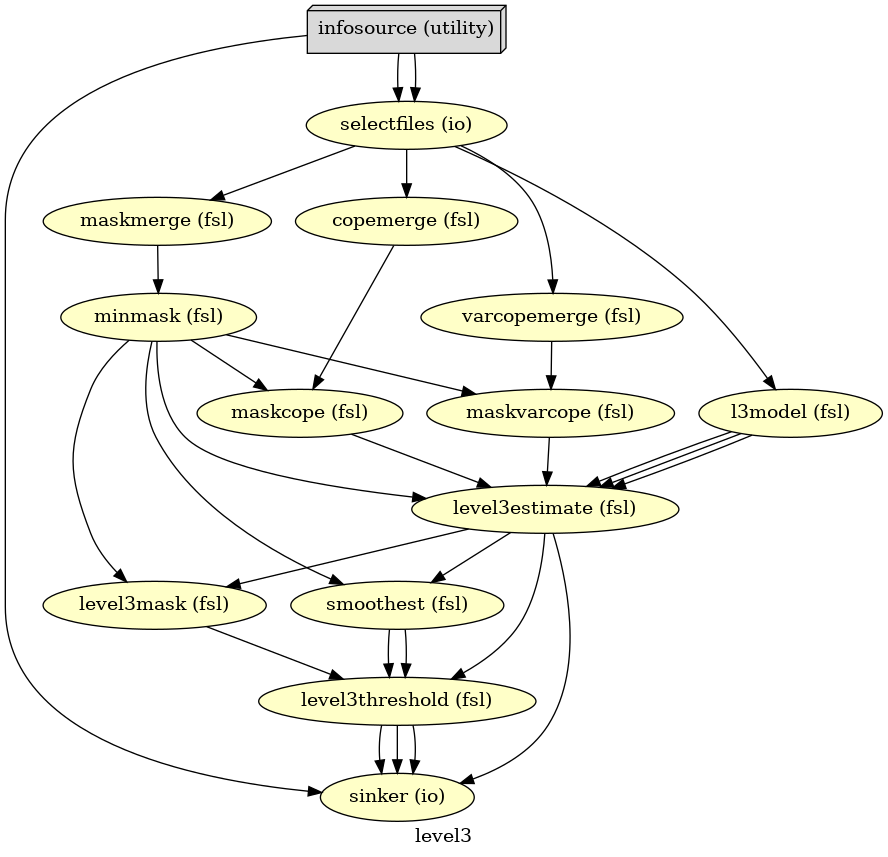

In [19]:
# Create 1st-level analysis output graph
wf.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(wf.base_dir, wf.name, 'graph.png'))

# Run

In [20]:
# Run Workflow
wf.run(plugin="MultiProc", plugin_args={"n_procs": 8})

221007-22:47:50,929 nipype.workflow INFO:
	 Workflow level3 settings: ['check', 'execution', 'logging', 'monitoring']
221007-22:47:55,940 nipype.workflow INFO:
	 Running in parallel.
221007-22:47:55,951 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 36 jobs ready. Free memory (GB): 28.17/28.17, Free processors: 8/8.
221007-22:47:56,56 nipype.workflow INFO:
	 [Node] Setting-up "level3.selectfiles" in "/home/pw/projects/thesis/out/level3/_contr_id_4_roi_id_Cere/selectfiles".
221007-22:47:56,58 nipype.workflow INFO:
	 [Node] Setting-up "level3.selectfiles" in "/home/pw/projects/thesis/out/level3/_contr_id_4_roi_id_FFGm/selectfiles".
221007-22:47:56,52 nipype.workflow INFO:
	 [Node] Setting-up "level3.selectfiles" in "/home/pw/projects/thesis/out/level3/_contr_id_4_roi_id_ACC/selectfiles".
221007-22:47:56,77 nipype.workflow INFO:
	 [Node] Setting-up "level3.selectfiles" in "/home/pw/projects/thesis/out/level3/_contr_id_4_roi_id_FFGl/selectfiles".
221007-22:47:56,80 nipype.workflo